<a href="https://colab.research.google.com/github/believehan/AI_Study_Notes/blob/main/7_3_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8(%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98_%EB%B0%A9%EC%8B%9D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets import FashionMNIST

fm_train = FashionMNIST(root='./data', train=True, download=True)
fm_test = FashionMNIST(root='./data', train=False, download=True)

train_input = fm_train.data
train_target = fm_train.targets
train_scaled = train_input / 255.0

from sklearn.model_selection import train_test_split

train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 269kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.05MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.42MB/s]


In [2]:
import torch.nn as nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 10)
)

In [3]:
import torch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [6]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

In [8]:
epochs = 20
batches = int(len(train_scaled) / 32)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i in range(batches):
        inputs = train_scaled[i*32:(i+1)*32].to(device)
        targets = train_target[i*32:(i+1)*32].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    model.eval()
    val_loss = 0
    with torch.no_grad():
      val_scaled = val_scaled.to(device)
      val_target = val_target.to(device)
      outputs = model(val_scaled)
      loss = criterion(outputs, val_target)
      val_loss = loss.item()
    train_hist.append(train_loss / batches)
    val_hist.append(val_loss)
    print(f"에포크: {epoch+1}, 훈련 손실: {train_loss/batches:.4f}, 검증 손실: {val_loss:.4f}")
    if best_loss == -1 or val_loss < best_loss:
      best_loss = val_loss
      early_stopping_counter = 0
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      early_stopping_counter += 1
      if early_stopping_counter >= patience:
        print(f"{epoch+1}번째 에포크에서 조기 종료 되었습니다.")
        break

에포크: 1, 훈련 손실: 0.4470, 검증 손실: 0.3971
에포크: 2, 훈련 손실: 0.4096, 검증 손실: 0.3725
에포크: 3, 훈련 손실: 0.3855, 검증 손실: 0.3570
에포크: 4, 훈련 손실: 0.3707, 검증 손실: 0.3519
에포크: 5, 훈련 손실: 0.3598, 검증 손실: 0.3475
에포크: 6, 훈련 손실: 0.3477, 검증 손실: 0.3415
에포크: 7, 훈련 손실: 0.3394, 검증 손실: 0.3400
에포크: 8, 훈련 손실: 0.3345, 검증 손실: 0.3347
에포크: 9, 훈련 손실: 0.3260, 검증 손실: 0.3333
에포크: 10, 훈련 손실: 0.3199, 검증 손실: 0.3290
에포크: 11, 훈련 손실: 0.3149, 검증 손실: 0.3316
에포크: 12, 훈련 손실: 0.3084, 검증 손실: 0.3290
에포크: 13, 훈련 손실: 0.3057, 검증 손실: 0.3277
에포크: 14, 훈련 손실: 0.2994, 검증 손실: 0.3307
에포크: 15, 훈련 손실: 0.2972, 검증 손실: 0.3348
15번째 에포크에서 조기 종료 되었습니다.


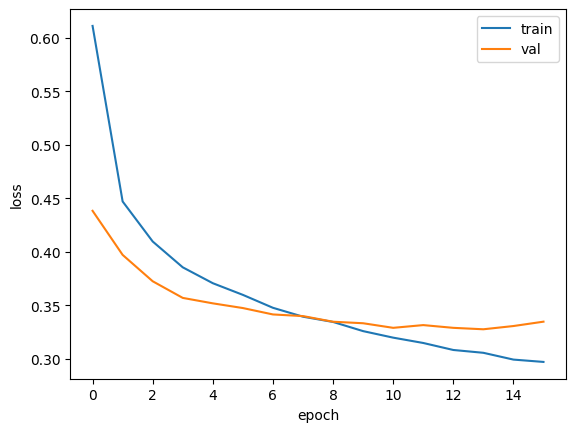

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [10]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

In [11]:
model.eval()
with torch.no_grad():
  val_scaled = val_scaled.to(device)
  val_target = val_target.to(val_scaled)
  outputs = model(val_scaled)
  predicts = torch.argmax(outputs, 1)
  correct = (predicts == val_target).sum().item()
  accuracy = correct / len(val_target)
  print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.8821
